In [1]:
#!unzip -q Composer_Dataset.zip

In [2]:
#!pip install pretty_midi
#!pip install mido librosa
#import pretty_midi
#import tensorflow as tf
#print(tf.config.list_physical_devices('GPU'))  # should list a GPU

In [27]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MIDI processing
import pretty_midi

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D,
    Dense, Dropout, Flatten, Concatenate
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.utils import to_categorical  # For one-hot encoding if needed
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


# Enable mixed precision for faster training on supported GPUs
mixed_precision.set_global_policy('mixed_float16')


## Utilities

In [28]:
# ---------- Plot helpers ----------
def plot_history_curves(history, title_prefix=""):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True, alpha=.3)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred, label_map, title="Confusion matrix"):
    idx_to_label = {v:k for k,v in label_map.items()}
    labels_order = [idx_to_label[i] for i in range(len(idx_to_label))]
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels_order))))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_order, yticklabels=labels_order)
    plt.title(title); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, label_map, title="Class distribution"):
    idx_to_label = {v:k for k,v in label_map.items()}
    names = [idx_to_label[i] for i in sorted(idx_to_label)]
    counts = [np.sum(labels==i) for i in range(len(names))]
    plt.figure(figsize=(6,4))
    plt.bar(names, counts)
    plt.title(title); plt.ylabel("Count"); plt.xticks(rotation=30, ha='right')
    plt.tight_layout(); plt.show()

def plot_history(history, title_prefix="Model"):
    """Plot training & validation accuracy and loss curves."""
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title_prefix} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title_prefix} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_lr_log(lr_log, title="Learning Rate over Epochs"):
    if not lr_log:
        return
    epochs = [e for e, _, _ in lr_log]
    lrs    = [lr for _, lr, _ in lr_log]
    plt.figure(figsize=(5,3))
    plt.plot(epochs, lrs, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title(title)
    plt.grid(True, alpha=.3)
    plt.tight_layout()
    plt.show()



##MIDI → piano roll
## Implementing Data Collection
## Implementing Data Pre-processing

In [29]:
# 1) Convert MIDI → fixed-size piano roll
def midi_to_pianoroll(midi_path, fs=25, num_frames=1200, binarize=True, velocity_clip=127):
    """
    Loads a MIDI, aligns start to t=0, converts to a piano roll (128 x num_frames).
    - fs: frames per second (25 → 1 col = 40ms)
    - num_frames: total time steps (e.g., 1200 → 48s at fs=25)
    - binarize: if True, roll is {0,1}; else normalized velocities in [0,1]
    """
    pm = pretty_midi.PrettyMIDI(midi_path)

    # Shift earliest note to time 0 for consistency
    starts = [n.start for inst in pm.instruments for n in inst.notes]
    if starts:
        shift = min(starts)
        if shift > 0:
            for inst in pm.instruments:
                for n in inst.notes:
                    n.start -= shift
                    n.end   -= shift

    roll = pm.get_piano_roll(fs=fs)            # shape: (128, T)
    # pad/truncate to num_frames
    if roll.shape[1] < num_frames:
        pad = num_frames - roll.shape[1]
        roll = np.pad(roll, ((0,0),(0,pad)), mode="constant")
    else:
        roll = roll[:, :num_frames]

    # normalize to [0,1]
    roll = np.clip(roll, 0, velocity_clip) / float(velocity_clip)

    show_pianoroll(piano_rolls[0], "Example input")

    if binarize:
        roll = (roll > 0).astype(np.float32)
    else:
        roll = roll.astype(np.float32)
    return roll  # (128, num_frames)


In [30]:
def show_pianoroll(roll, title="Piano roll (pitches 40–90)"):
    plt.figure(figsize=(10,3))
    plt.imshow(roll[40:90, :], aspect='auto', origin='lower')
    plt.colorbar(label='Velocity/Activation')
    plt.xlabel('Time steps'); plt.ylabel('MIDI pitch'); plt.title(title)
    plt.tight_layout(); plt.show()

 ## 3. Feature Extraction

 Features are extracted by the following reference published site:

 **Reference** https://app.readytensor.ai/publications/music-composer-classification-of-midi-files-using-deep-learning-qZ9m02sVKl8C



**Function Purpose**  
This function extracts 13 high-level musical features from a piano roll representation.

**Piano Roll Structure**  
- Rows represent MIDI pitches (0–127).  
- Columns represent time steps.  
- Each value indicates note velocity (intensity) at a given pitch and time.  

**Processing Steps**  

1. **Note Event Detection**  
   - Scans each pitch line to detect "note on" and "note off" transitions.  
   - Records pitch, start time, end time, and maximum velocity for each note.  

2. **Feature Computation**  
   The following 13 features are calculated:  
   1. **Tempo** – Estimated BPM from onset intervals.  
   2. **Note Density** – Average notes per second.  
   3. **Pitch Variance** – Variability of pitches used.  
   4. **Velocity Mean** – Average loudness of notes.  
   5. **Velocity Max** – Maximum loudness in the piece.  
   6. **Velocity Variance** – Loudness variability.  
   7. **Polyphony** – Average simultaneous notes.  
   8. **Rhythmic Density** – Same as note density for piano rolls.  
   9. **Average Pitch Interval** – Mean pitch difference between consecutive notes.  
   10. **Chord Density** – Proportion of chord notes (notes starting within 50 ms of another).  
   11. **Pitch Transitions** – Frequency of pitch changes.  
   12. **Average Note Duration** – Mean note length in seconds.  
   13. **Estimated Number of Instruments** – Based on contiguous pitch activity > 1 octave.  

**Output**  
- Returns a NumPy array of shape `(13,)` with features in the fixed order above.  
- Returns an all-zero array if no notes are detected or if an error occurs.  

In [31]:
def extract_features_from_piano_roll(piano_roll, fs=25, thr=0.1):

    """
    Extracts EXACT 13 hand-crafted features from a piano roll matrix.

    Input:
    - piano_roll: NumPy array of shape (128, T), where:
    128 = MIDI pitches (rows)
    T   = time steps (columns)
    - fs: Frames per second (default=25)
    - thr: Threshold for note activation (default=0.1)

    Steps:
    1. **Reconstruct Notes**:
     - Detect note start/end times based on threshold.
     - Record pitch, start time, end time, and velocity.

    2. **Compute 13 Features**:
     1) Tempo (BPM, estimated from onset intervals)
     2) Note density (notes per second)
     3) Pitch variance
     4) Velocity mean
     5) Velocity max
     6) Velocity variance
     7) Polyphony (average simultaneous notes)
     8) Rhythmic density (same as note density here)
     9) Average pitch interval
     10) Chord density (proportion of notes starting within 50 ms)
     11) Pitch transitions ratio
     12) Average note duration
     13) Estimated number of instruments (based on pitch band activity)

   Output:
    - NumPy array of length 13 (dtype=np.float32) in fixed order.
    - Returns all zeros if no notes are detected.

   """

    try:
        piano_roll = piano_roll.astype(np.float32, copy=False)
        n_pitches, n_time_steps = piano_roll.shape
        duration = max(1e-8, n_time_steps / float(fs))

        # --- reconstruct notes ---
        notes = []
        for pitch in range(n_pitches):
            pr = piano_roll[pitch]
            in_note, start_time = False, 0.0
            for t in range(n_time_steps):
                if pr[t] > thr and not in_note:
                    start_time, in_note = t / fs, True
                elif pr[t] <= thr and in_note:
                    end_time = t / fs
                    v = float(np.max(pr[int(start_time*fs):t]) * 127.0)
                    notes.append((pitch, start_time, end_time, v))
                    in_note = False
            if in_note:
                end_time = duration
                v = float(np.max(pr[int(start_time*fs):]) * 127.0)
                notes.append((pitch, start_time, end_time, v))

        if not notes:
            return np.zeros(13, dtype=np.float32)

        notes.sort(key=lambda x: x[1])
        pitches = np.array([n[0] for n in notes], dtype=np.float32)
        vels    = np.array([n[3] for n in notes], dtype=np.float32)

        # 1) tempo (rough from onsets)
        if len(notes) > 1:
            onsets = np.array([n[1] for n in notes[:50]], dtype=np.float32)
            diffs  = np.diff(onsets)
            diffs  = diffs[diffs > 0]
            avg_it = float(np.mean(diffs)) if diffs.size else 0.5
            tempo  = 60.0 / max(avg_it, 1e-6)
        else:
            tempo = 120.0
        tempo = float(np.clip(tempo, 60.0, 200.0))

        # 2) note density
        note_density = len(notes) / duration

        # 3) pitch variance
        pitch_variance = float(np.var(pitches)) if pitches.size else 0.0

        # 4–6) velocity stats
        velocity_mean = float(np.mean(vels)) if vels.size else 0.0
        velocity_max  = float(np.max(vels))  if vels.size else 0.0
        velocity_var  = float(np.var(vels))  if vels.size else 0.0

        # 7) polyphony (avg active notes per frame)
        polyphony = float(np.mean(np.sum(piano_roll > thr, axis=0)))

        # 8) rhythmic density (same as note_density here)
        rhythmic_density = note_density

        # 9) avg pitch interval & 11) pitch transitions
        if pitches.size > 1:
            intervals = np.abs(np.diff(pitches))
            avg_pitch_interval = float(np.mean(intervals)) if intervals.size else 0.0
            pitch_transitions  = float(np.mean(pitches[1:] != pitches[:-1]))
        else:
            avg_pitch_interval = 0.0
            pitch_transitions  = 0.0

        # 10) chord density (onsets within 50 ms)
        chord_count = sum(
            1 for i in range(len(notes) - 1)
            if abs(notes[i+1][1] - notes[i][1]) < 0.05
        )
        chord_density = chord_count / len(notes)

        # 12) avg note duration
        durs = np.array([n[2] - n[1] for n in notes], dtype=np.float32)
        avg_note_duration = float(np.mean(durs)) if durs.size else 0.0

        # 13) estimated instruments (contiguous active pitch bands > 1 octave)
        activity = np.sum(piano_roll > thr, axis=1)
        bands, start = [], None
        for p in range(n_pitches):
            if activity[p] > 0 and start is None:
                start = p
            elif activity[p] == 0 and start is not None:
                if p - start > 12:
                    bands.append((start, p-1))
                start = None
        if start is not None:
            bands.append((start, n_pitches-1))
        num_instrument = float(max(1, len(bands)))

        feat = np.array([
            tempo, note_density, pitch_variance, velocity_mean, velocity_max,
            velocity_var, polyphony, rhythmic_density, avg_pitch_interval,
            chord_density, pitch_transitions, avg_note_duration, num_instrument
        ], dtype=np.float32)
        return feat

    except Exception as e:
        print(f"Error extracting features: {e}")
        return np.zeros(13, dtype=np.float32)

#3. Data Pre-Processing
This function ensures that a piano roll array has a fixed number of time steps (target_length).

- If the piano roll is shorter than the target length, it pads zeros at the end (right side) to match the desired length.

- If it is longer, it crops the middle portion of the roll, keeping the content centered and trimming equally from both sides.

This standardization ensures all inputs to the model have the same time dimension.

In [32]:
def center_crop(roll, target_length=500):
  """
  Center-crops or pads a piano roll to a fixed time length.

  Input:
   - roll: NumPy array of shape (128, T), where:
    128 = MIDI pitches (rows)
    T   = time steps (columns)
   - target_length: Desired number of time steps (default=500)

  Steps:
   1. If the roll is **shorter than or equal to** target_length:
     - Pads zeros at the end (time axis) so the total length = target_length.

   2. If the roll is **longer** than target_length:
     - Crops the center portion so the final length = target_length.

   Output:
     - NumPy array of shape (128, target_length) with either:
     • extra padding (if too short)
     • or central crop (if too long)
   """

  if roll.shape[1] <= target_length:
        pad_width = target_length - roll.shape[1]
        return np.pad(roll, ((0,0), (0, pad_width)), mode='constant')

  start = (roll.shape[1] - target_length) // 2
  return roll[:, start:start+target_length]

## 4. Model Building
This function builds a hybrid deep learning model that combines CNN-based features from piano rolls with 13 handcrafted MIDI features for music classification.

**CNN branch:**

- Processes the piano roll input (128 × 500 × 1) through three convolutional blocks with batch normalization, max pooling, dropout, and global average pooling.

- Learns spatial–temporal patterns of notes, rhythms, and harmonics.

- Outputs a 32-dimensional CNN feature vector.

**Handcrafted features branch:**

- Takes the precomputed 13-dimensional music features (e.g., tempo, note density, pitch variance, etc.).

- Passes through fully connected layers with dropout.

- Outputs a 16-dimensional handcrafted feature vector.

**Fusion & classification:**

- The two feature vectors are concatenated.

- Fully connected layers with dropout are applied.

A final softmax layer outputs predictions for num_classes categories (default: 9 composers).

This architecture leverages both learned and human-engineered features, improving classification performance over using either alone.



In [33]:
def create_hybrid_cnn_handcrafted(cnn_input_shape=(128, 500, 1), handcrafted_dim=13, num_classes=9):
    """Hybrid model: CNN for piano rolls + exact hand-crafted features"""
    """
    Builds a **hybrid deep learning model** that combines:
    1. CNN branch → Learns patterns from piano roll input (128 × 500 image-like matrix).
    2. Dense NN branch → Processes EXACT 13 hand-crafted features.

   Steps:
    - **CNN Branch (Piano Rolls)**:
    - Conv2D layers progressively extract temporal & pitch patterns from piano rolls.
    - Batch Normalization stabilizes training.
    - MaxPooling2D reduces dimensionality and captures key features.
    - Dropout prevents overfitting.
    - GlobalAveragePooling2D summarizes feature maps.
    - Dense layers convert learned patterns into a compact feature vector.

    - **Hand-Crafted Features Branch**:
    - Dense layers process the 13 pre-computed features.
    - Dropout for regularization.
    - Outputs a smaller feature vector.

    - **Fusion**:
    - Concatenates CNN features with hand-crafted features.
    - Dense layers learn from both types of data jointly.
    - Final Dense layer with softmax outputs class probabilities for `num_classes` composers.

    Returns:
    - A compiled Keras Model ready for training with two inputs:
    1. Piano roll data → shape `(128, 500, 1)`
    2. Hand-crafted features → shape `(13,)`
    """

    # CNN branch for piano roll patterns
    cnn_input = Input(shape=cnn_input_shape, name='piano_roll_input')

    # Simple but effective CNN (based on successful models)
    x_cnn = Conv2D(16, (6, 8), strides=(3, 4), padding='same', activation='relu')(cnn_input)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = MaxPooling2D((2, 2))(x_cnn)
    x_cnn = Dropout(0.1)(x_cnn)

    x_cnn = Conv2D(32, (4, 6), strides=(2, 2), padding='same', activation='relu')(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = MaxPooling2D((2, 2))(x_cnn)
    x_cnn = Dropout(0.15)(x_cnn)

    x_cnn = Conv2D(48, (3, 3), padding='same', activation='relu')(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)
    x_cnn = GlobalAveragePooling2D()(x_cnn)

    cnn_features = Dense(64, activation='relu')(x_cnn)
    cnn_features = Dropout(0.2)(cnn_features)
    cnn_features = Dense(32, activation='relu', name='cnn_features')(cnn_features)

    # Hand-crafted features branch (EXACT 13 FEATURES)
    handcrafted_input = Input(shape=(handcrafted_dim,), name='handcrafted_input')

    # Process proven features
    x_hc = Dense(64, activation='relu')(handcrafted_input)
    x_hc = Dropout(0.2)(x_hc)
    x_hc = Dense(32, activation='relu')(x_hc)
    x_hc = Dropout(0.1)(x_hc)
    handcrafted_features = Dense(16, activation='relu', name='handcrafted_features')(x_hc)

    # Combine both branches
    combined = Concatenate(name='feature_fusion')([cnn_features, handcrafted_features])

    # Final classification
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.15)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[cnn_input, handcrafted_input], outputs=outputs)
    return model

This function builds a fully connected neural network that uses only the 13 handcrafted MIDI features (e.g., tempo, note density, pitch variance) as input for music classification.

Input layer: Accepts a vector of handcrafted_dim features (default: 13).

Hidden layers: Four dense (fully connected) layers with ReLU activation and progressively smaller sizes (128 → 64 → 32 → 16 neurons) to learn hierarchical feature interactions.

Dropout layers: Placed after each dense layer to reduce overfitting (dropout rates from 0.3 to 0.15).

Output layer: Softmax activation with num_classes units (default: 9), producing class probabilities.

This model focuses entirely on pre-engineered features without learning directly from raw piano roll data. It serves as a baseline to compare against CNN-based or hybrid architectures.

In [34]:
def create_handcrafted_only_nn(handcrafted_dim=13, num_classes=9, l2_reg=0.0, dropout_rate=0.2):
    reg = regularizers.l2(l2_reg) if l2_reg and l2_reg > 0 else None
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(handcrafted_dim,)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=reg),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model


## Data Pre-processing:
It loads already-prepared inputs (saved piano rolls as .npy) and standardizes label IDs. The class-distribution plot is also part of preprocessing/EDA.

## Feature Extraction:
 It calls extract_features_from_piano_roll(...) to compute 13 hand-crafted features (tempo, density, etc.).

In [35]:
"""
Loads dataset from the given CSV, where each row contains a path to a saved piano roll
and its composer label. For each file:
 - Loads the piano roll (NumPy array)
 - Extracts the EXACT 13 pre-defined hand-crafted features
 - Maps the composer label to a numeric ID

Returns:
 - piano_rolls (NumPy array)
 - handcrafted_features (NumPy array)
 - labels (numeric array)
 - label_map (dict mapping composer name → numeric ID)
"""



def load_data_with_exact_features(csv_path):
    """Load piano roll data and extract exact 13 features"""
    df = pd.read_csv(csv_path)
    unique_labels = sorted(df['label'].unique())
    label_map = {label: idx for idx, label in enumerate(unique_labels)}

    print(f"Loading {len(df)} files and extracting exact features...")

    piano_rolls = []
    handcrafted_features = []
    labels = []

    for i, (_, row) in enumerate(df.iterrows()):
        #if i % 25 == 0:
         #   print(f"Processed {i}/{len(df)} files")
        try:
            # Load piano roll
            piano_roll = np.load(row['file_path'])
            # Extract exact 13 features from piano roll
            features = extract_features_from_piano_roll(piano_roll)
            piano_rolls.append(piano_roll)
            handcrafted_features.append(features)
            labels.append(label_map[row['label']])
        except Exception as e:
            print(f"Error processing {row['file_path']}: {e}")
            continue

    print(f"Successfully processed {len(piano_rolls)} files")
    print(f"Extracted {len(handcrafted_features[0])} hand-crafted features per sample")
    plot_class_distribution(np.array(labels), label_map, "All samples per class")
    return (np.array(piano_rolls),
            np.array(handcrafted_features),
            np.array(labels),
            label_map)


This custom Keras callback logs the learning rate and validation loss at the end of each training epoch.
It automatically handles plain optimizers, mixed-precision (LossScaleOptimizer), and learning rate schedules, storing the results in a list for later visualization or analysis.

In [36]:
class LrTracker(tf.keras.callbacks.Callback):
    def __init__(self, store_list=None):
        super().__init__()
        self.store = store_list if store_list is not None else []

    def _unwrap_optimizer(self, opt):
        # Unwrap LossScaleOptimizer (and other wrappers)
        while hasattr(opt, "optimizer"):
            opt = opt.optimizer
        return opt

    def _read_scalar(self, x):
        # Try to read a scalar float from tensor/variable
        try:
            return float(tf.keras.backend.get_value(x))
        except Exception:
            return None

    def _get_lr_value(self):
        opt = self._unwrap_optimizer(self.model.optimizer)

        # Prefer learning_rate; if missing, try lr
        lr_attr = None
        if hasattr(opt, "learning_rate"):
            lr_attr = getattr(opt, "learning_rate")
        elif hasattr(opt, "lr"):
            lr_attr = getattr(opt, "lr")

        if lr_attr is None:
            return None

        # If tensor/variable
        if isinstance(lr_attr, (tf.Variable, tf.Tensor)):
            val = self._read_scalar(lr_attr)
            if val is not None:
                return val

        # If schedule/callable
        if callable(lr_attr):
            try:
                step = tf.keras.backend.get_value(self.model.optimizer.iterations)
                val = lr_attr(step)
                return self._read_scalar(val) if isinstance(val, (tf.Variable, tf.Tensor)) else float(val)
            except Exception:
                return None

        # If plain python/np number
        try:
            return float(lr_attr)
        except Exception:
            return None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr_val = self._get_lr_value()
        val_loss = logs.get("val_loss")
        self.store.append((epoch + 1, lr_val, val_loss))
        if lr_val is not None and val_loss is not None:
            print(f"Epoch {epoch+1:02d} | lr={lr_val:.6f} | val_loss={val_loss:.4f}")
        elif val_loss is not None:
            print(f"Epoch {epoch+1:02d} | lr=? | val_loss={val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1:02d} | lr={lr_val}")


In [37]:
results_log = []

def log_result(name, history, test_acc, best_epoch=None, notes=None):
    entry = {
        "run": name,
        "best_val_acc": float(np.max(history.history['val_accuracy'])),
        "final_val_loss": float(history.history['val_loss'][-1]),
        "test_acc": float(test_acc),
        "best_epoch": int(np.argmin(history.history['val_loss']) + 1) if best_epoch is None else best_epoch,
        "epochs_ran": len(history.history['loss']),
        "notes": "LR=5e-3; Dropout=0.3; No L2"
    }
    results_log.append(entry)
    return entry


## 5. CNN  Model Training and Model optimization. : HYBRID Model

In [38]:
def train_hybrid_model(piano_rolls, handcrafted_features, labels, label_map):
    """
    Trains a HYBRID model that combines:
    - CNN branch: processes cropped piano roll data (128 × 500 × 1)
    - Dense branch: processes EXACT 13 hand-crafted features

    Steps:
    1. Splits dataset into train/validation/test sets (stratified by composer label)
    2. Crops & reshapes piano rolls; scales hand-crafted features
    3. Builds the hybrid CNN + Dense network
    4. Compiles with Adam optimizer & categorical cross-entropy loss
    5. Trains the model with class weights and callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
    6. Returns best validation accuracy, test accuracy, and the trained model
    """

    print("\nTRAINING HYBRID CNN + EXACT FEATURES")
    print("="*60)
    run_name = "Hybrid CNN + Hand-crafted"

    # Split data (60/20/20 via two splits), stratified
    X_piano_temp, X_piano_test, X_hc_temp, X_hc_test, y_temp, y_test = train_test_split(
        piano_rolls, handcrafted_features, labels, test_size=0.20, stratify=labels, random_state=42
    )
    X_piano_train, X_piano_val, X_hc_train, X_hc_val, y_train, y_val = train_test_split(
        X_piano_temp, X_hc_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    # Piano roll crop + channel dim
    X_piano_train_proc = np.array([center_crop(roll, target_length=500) for roll in X_piano_train])[..., np.newaxis]
    X_piano_val_proc   = np.array([center_crop(roll, target_length=500) for roll in X_piano_val])[..., np.newaxis]
    X_piano_test_proc  = np.array([center_crop(roll, target_length=500) for roll in X_piano_test])[..., np.newaxis]

    # Scale handcrafted features
    scaler = StandardScaler()
    X_hc_train_scaled = scaler.fit_transform(X_hc_train)
    X_hc_val_scaled   = scaler.transform(X_hc_val)
    X_hc_test_scaled  = scaler.transform(X_hc_test)

    print(f"Piano roll data: {X_piano_train_proc.shape}")
    print(f"Hand-crafted features: {X_hc_train_scaled.shape}")

    # Build model
    model = create_hybrid_cnn_handcrafted(
        cnn_input_shape=(128, 500, 1),
        handcrafted_dim=13,
        num_classes=len(label_map)
    )
    model.compile(optimizer=Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"Hybrid model parameters: {model.count_params():,}")

    # Labels one-hot
    y_train_oh = tf.keras.utils.to_categorical(y_train, len(label_map))
    y_val_oh   = tf.keras.utils.to_categorical(y_val,   len(label_map))
    y_test_oh  = tf.keras.utils.to_categorical(y_test,  len(label_map))

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    # Callbacks
    lr_log = []
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0),
        ModelCheckpoint('hybrid_exact_features.keras', monitor='val_loss', save_best_only=True, verbose=0),
        LrTracker(store_list=lr_log)
    ]

    # Train
    history = model.fit(
        [X_piano_train_proc, X_hc_train_scaled], y_train_oh,
        validation_data=([X_piano_val_proc, X_hc_val_scaled], y_val_oh),
        epochs=80,
        batch_size=16,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=0
    )

    # Metrics
    best_val_acc = float(np.max(history.history['val_accuracy']))
    test_loss, test_acc = model.evaluate([X_piano_test_proc, X_hc_test_scaled], y_test_oh, verbose=0)

    # Predictions for confusion matrix
    y_pred_probs = model.predict([X_piano_test_proc, X_hc_test_scaled], verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = y_test

    # Plots
    plot_history(history, title_prefix="Hybrid (CNN + Features)")
    plot_lr_log(lr_log, title="Hybrid – LR Schedule")
    plot_confusion(y_true, y_pred, label_map, title="Hybrid – Confusion Matrix")

    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

    notes = "LR=5e-3; Dropout=0.3; No L2"
    # Log results for comparison table
    results_log.append({
        "run": run_name,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "best_epoch": np.argmax(history.history['val_accuracy']) + 1,
        "epochs_ran": len(history.history['val_accuracy']),
        "notes": notes
    })

    return best_val_acc, test_acc, model

## 5. CNN Model Training and Model Optimization: HANDCRAFTED Model

In [39]:
def train_handcrafted_only(handcrafted_features, labels, label_map):
    """
    Trains a neural network using ONLY the EXACT 13 hand-crafted features
    (no CNN, no raw piano rolls).

    Steps:
    1. Splits the hand-crafted feature dataset into train/validation/test sets (stratified by composer label)
    2. Scales features with StandardScaler
    3. Builds a simple dense neural network for classification
    4. Compiles with Adam optimizer & categorical cross-entropy loss
    5. Trains with class weighting to handle label imbalance
    6. Returns the best validation accuracy and final test accuracy
    """
    print("\nTRAINING NN WITH EXACT FEATURES ONLY")
    print("="*50)
    run_name = "Hybrid CNN + Hand-crafted"
    # Split (60/20/20)
    X_temp, X_test, y_temp, y_test = train_test_split(
        handcrafted_features, labels, test_size=0.2, stratify=labels, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # One-hot labels
    n_classes = len(label_map)
    y_train_oh = tf.keras.utils.to_categorical(y_train, n_classes)
    y_val_oh   = tf.keras.utils.to_categorical(y_val,   n_classes)
    y_test_oh  = tf.keras.utils.to_categorical(y_test,  n_classes)

    # Class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    results = []

    # -------- Baseline --------
    model_base = create_handcrafted_only_nn(handcrafted_dim=13, num_classes=n_classes,
                                            l2_reg=0.0, dropout_rate=0.2)
    model_base.compile(optimizer=Adam(5e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks_base = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0),
        ModelCheckpoint('handcrafted_baseline.keras', monitor='val_loss', save_best_only=True, verbose=0),
    ]
    history_base = model_base.fit(
        X_train_scaled, y_train_oh,
        validation_data=(X_val_scaled, y_val_oh),
        epochs=100, batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks_base, verbose=0
    )
    test_loss_base, test_acc_base = model_base.evaluate(X_test_scaled, y_test_oh, verbose=0)
    y_pred_base = np.argmax(model_base.predict(X_test_scaled, verbose=0), axis=1)

    plot_history(history_base, title_prefix="Baseline")
    plot_confusion(y_test, y_pred_base, label_map, title="Baseline – Confusion Matrix")


    results.append(log_result("Baseline", history_base, test_acc_base, notes="LR=5e-3; L2=0; dropout=0.2"))

    # -------- Fine-tuned --------
    model_ft = create_handcrafted_only_nn(handcrafted_dim=13, num_classes=n_classes,
                                          l2_reg=1e-4, dropout_rate=0.3)
    model_ft.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    lr_log = []
    callbacks_ft = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0),
        ModelCheckpoint('handcrafted_finetuned.keras', monitor='val_loss', save_best_only=True, verbose=0),
        LrTracker(store_list=lr_log)
    ]
    history_ft = model_ft.fit(
        X_train_scaled, y_train_oh,
        validation_data=(X_val_scaled, y_val_oh),
        epochs=100, batch_size=32,
        class_weight=class_weight_dict,
        callbacks=callbacks_ft, verbose=0
    )
    test_loss_ft, test_acc_ft = model_ft.evaluate(X_test_scaled, y_test_oh, verbose=0)
    y_pred_ft = np.argmax(model_ft.predict(X_test_scaled, verbose=0), axis=1)

    plot_history(history_ft, title_prefix="Fine-tuned (LR=1e-3, L2=1e-4, Dropout=0.3)")
    plot_lr_log(lr_log, title="Fine-tuned – LR Schedule")
    plot_confusion(y_test, y_pred_ft, label_map, title="Fine-tuned – Confusion Matrix")

    results.append(log_result("Fine-tuned", history_ft, test_acc_ft,
                              notes="LR=1e-3; L2=1e-4; dropout=0.3"))

    # -------- Summary table --------
    df_results = pd.DataFrame(results).sort_values("best_val_acc", ascending=False)
    print("\nSUMMARY (Hand-crafted Only)")
    display(df_results[["run","best_val_acc","test_acc","best_epoch","epochs_ran","notes"]])

    # --- NEW: show fine-tuning improvements succinctly ---
    base_best_val = float(np.max(history_base.history['val_accuracy']))
    ft_best_val   = float(np.max(history_ft.history['val_accuracy']))
    print(f"\nFine-tuning Δ (val acc): +{(ft_best_val - base_best_val):.4f}")
    print(f"Baseline test acc: {test_acc_base:.4f}  |  Fine-tuned test acc: {test_acc_ft:.4f}  |  Δ: +{(test_acc_ft - test_acc_base):.4f}")

    # --- NEW: small comparison bar chart ---
    plt.figure(figsize=(5,3))
    bars = ["Baseline", "Fine-tuned"]
    vals = [base_best_val, ft_best_val]
    plt.bar(bars, vals)
    plt.ylim(0, 1)
    plt.title("Best Validation Accuracy: Baseline vs Fine-tuned")
    plt.ylabel("Val Accuracy")
    plt.tight_layout(); plt.show()

    # --- log to a global results_log if present ---
    try:
        results_log.append({
            "run": "Hand-crafted Baseline",
            "best_val_acc": base_best_val,
            "test_acc": test_acc_base,
            "best_epoch": int(np.argmax(history_base.history['val_accuracy']) + 1),
            "epochs_ran": len(history_base.history['val_accuracy']),
            "notes": "LR=5e-3; L2=0; dropout=0.2"
        })
        results_log.append({
            "run": "Hand-crafted Fine-tuned",
            "best_val_acc": ft_best_val,
            "test_acc": test_acc_ft,
            "best_epoch": int(np.argmax(history_ft.history['val_accuracy']) + 1),
            "epochs_ran": len(history_ft.history['val_accuracy']),
            "notes": "LR=1e-3; L2=1e-4; dropout=0.3"
        })
    except NameError:
        pass  # results_log not defined globally; ignore

    return {
        "baseline":   {"history": history_base, "test_acc": test_acc_base, "y_pred": y_pred_base},
        "fine_tuned": {"history": history_ft,   "test_acc": test_acc_ft,   "y_pred": y_pred_ft},
        "summary": df_results
    }

## 6. Model Evaluation and comparision


In [40]:
def comprehensive_comparison(csv_path):

    """
    Runs a full performance comparison between two approaches:

    1. Hand-crafted Only:
     - Uses ONLY the EXACT 13 hand-crafted features
     - Trains a fully connected NN
     - Evaluates on validation & test sets

    2. Hybrid CNN + Hand-crafted:
     - Uses CNN on piano rolls + the 13 hand-crafted features
     - Merges learned & hand-crafted features for classification
     - Evaluates on validation & test sets

    Process:
     - Loads dataset from CSV (piano roll arrays + features + labels)
     - Trains and evaluates both models
     - Prints side-by-side validation and test accuracies
     - Highlights the best-performing method
     - Compares the results to a previous CNN baseline and target accuracy
     - Returns a dictionary: {method_name: (val_acc, test_acc)}
    """


    # Load data
    print("COMPREHENSIVE COMPARISON: EXACT FEATURES")

    piano_rolls, handcrafted_features, labels, label_map = load_data_with_exact_features(csv_path)
    print(f"Dataset: {len(piano_rolls)} samples, {len(label_map)} composers")

    results = {}

    # 1) Hand-crafted only (returns dict with 'summary')
    hc_out = train_handcrafted_only(handcrafted_features, labels, label_map)
    # take the best row from its summary
    hc_row = hc_out["summary"].iloc[0]
    hc_val_acc = float(hc_row["best_val_acc"])
    hc_test_acc = float(hc_row["test_acc"])
    results["Hand-crafted Only"] = (hc_val_acc, hc_test_acc)

    # 2) Hybrid (this returns (val_acc, test_acc, model))
    hybrid_val_acc, hybrid_test_acc, _ = train_hybrid_model(
        piano_rolls, handcrafted_features, labels, label_map
    )
    results["Hybrid CNN + Hand-crafted"] = (hybrid_val_acc, hybrid_test_acc)

    # Print table
    print("\nFINAL COMPARISON RESULTS:")
    print("=" * 60)
    print(f"{'Method':<30} {'Val Acc':<10} {'Test Acc'}")
    print("-" * 50)
    for method, (val_acc, test_acc) in results.items():
        print(f"{method:<30} {val_acc:.4f}     {test_acc:.4f}")

    best_method = max(results.items(), key=lambda x: x[1][0])
    print("BEST METHOD:", best_method[0])
    print("BEST VALIDATION ACCURACY:", f"{best_method[1][0]:.4f}")
    print("TEST ACCURACY:", f"{best_method[1][1]:.4f}")

    print("\nCOMPARISON WITH TARGETS:")
    print("Previous CNN: 54.05%")
    print("Target: 59.46%")
    print("This approach:", f"{best_method[1][0]:.1%}")
    if best_method[1][0] > 0.5946:
        improvement = (best_method[1][0] - 0.5946) * 100
        print("SUCCESS! Beat target by +", f"{improvement:.1f}%")

    return results

## Main function



CNN + EXACT HAND-CRAFTED FEATURES
Using proven 13-feature extraction pipeline
COMPREHENSIVE COMPARISON: EXACT FEATURES
Loading 369 files and extracting exact features...
Successfully processed 369 files
Extracted 13 hand-crafted features per sample


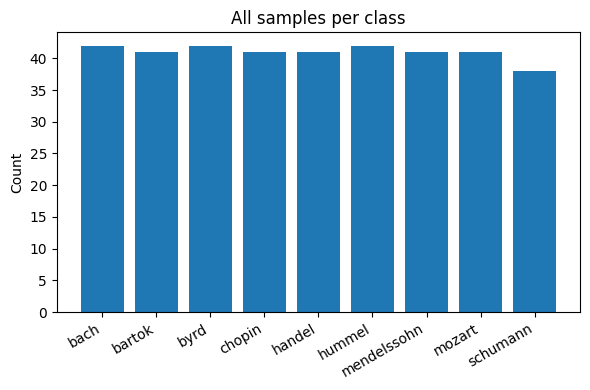

Dataset: 369 samples, 9 composers

TRAINING NN WITH EXACT FEATURES ONLY


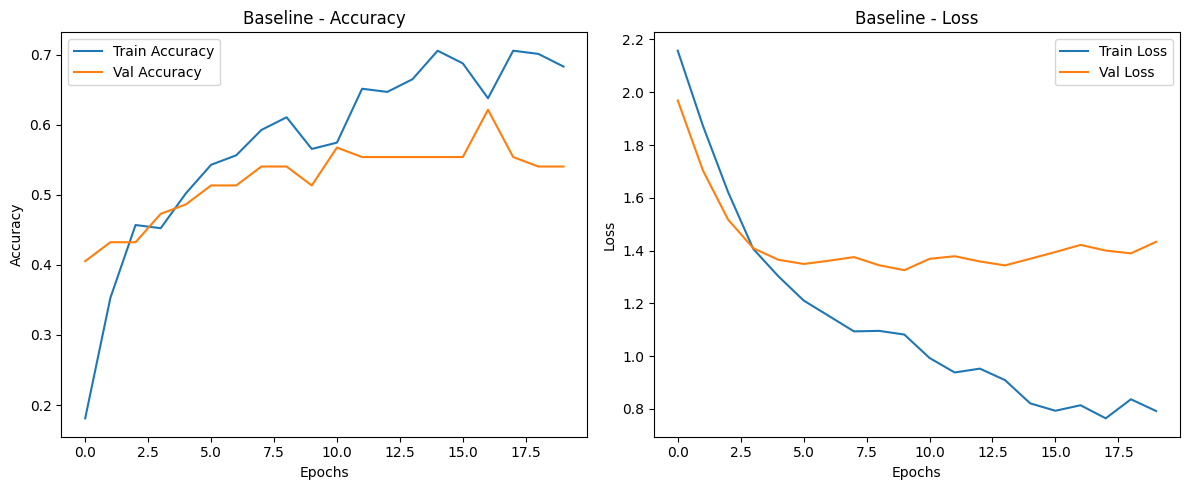

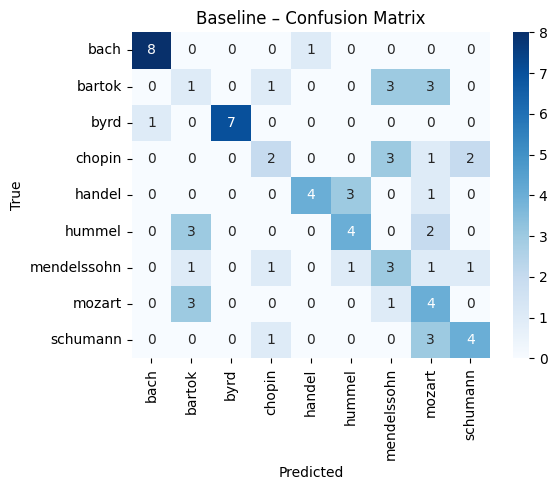

Epoch 01 | lr=0.001000 | val_loss=2.0899
Epoch 02 | lr=0.001000 | val_loss=2.0365
Epoch 03 | lr=0.001000 | val_loss=1.9849
Epoch 04 | lr=0.001000 | val_loss=1.9289
Epoch 05 | lr=0.001000 | val_loss=1.8707
Epoch 06 | lr=0.001000 | val_loss=1.8132
Epoch 07 | lr=0.001000 | val_loss=1.7582
Epoch 08 | lr=0.001000 | val_loss=1.7075
Epoch 09 | lr=0.001000 | val_loss=1.6546
Epoch 10 | lr=0.001000 | val_loss=1.6071
Epoch 11 | lr=0.001000 | val_loss=1.5565
Epoch 12 | lr=0.001000 | val_loss=1.5161
Epoch 13 | lr=0.001000 | val_loss=1.4819
Epoch 14 | lr=0.001000 | val_loss=1.4557
Epoch 15 | lr=0.001000 | val_loss=1.4304
Epoch 16 | lr=0.001000 | val_loss=1.4072
Epoch 17 | lr=0.001000 | val_loss=1.3864
Epoch 18 | lr=0.001000 | val_loss=1.3690
Epoch 19 | lr=0.001000 | val_loss=1.3549
Epoch 20 | lr=0.001000 | val_loss=1.3402
Epoch 21 | lr=0.001000 | val_loss=1.3325
Epoch 22 | lr=0.001000 | val_loss=1.3289
Epoch 23 | lr=0.001000 | val_loss=1.3272
Epoch 24 | lr=0.001000 | val_loss=1.3185
Epoch 25 | lr=0.

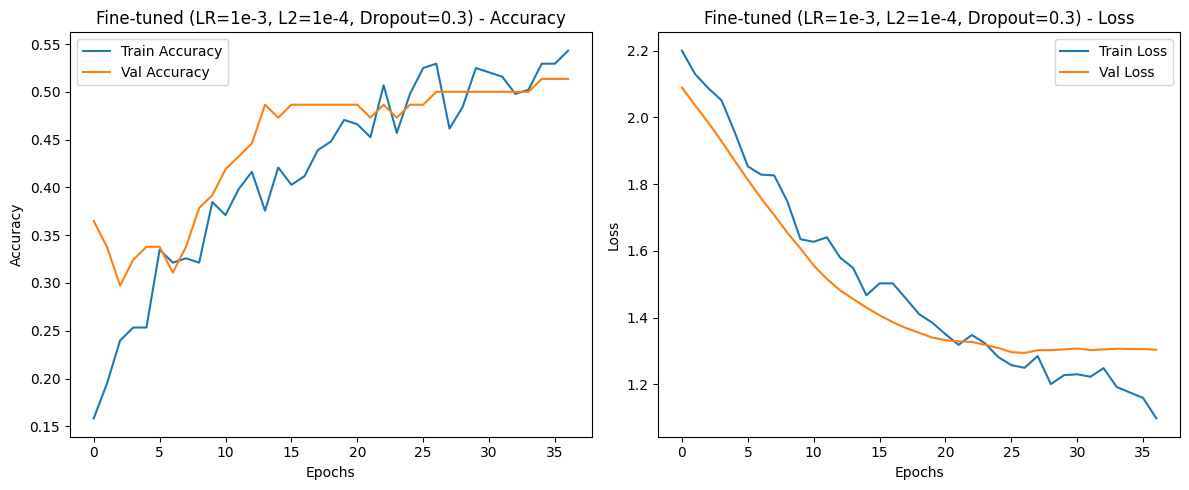

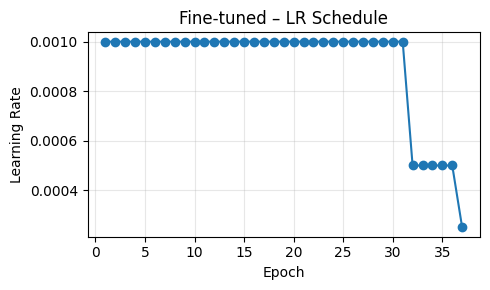

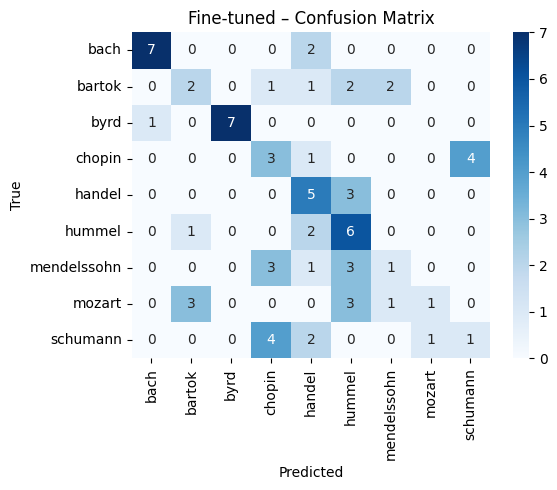


SUMMARY (Hand-crafted Only)


,run,best_val_acc,test_acc,best_epoch,epochs_ran,notes
0,Baseline,0.621622,0.500000,10,20,LR=5e-3; Dropout=0.3; No L2
1,Fine-tuned,0.513514,0.445946,27,37,LR=5e-3; Dropout=0.3; No L2



Fine-tuning Δ (val acc): +-0.1081
Baseline test acc: 0.5000  |  Fine-tuned test acc: 0.4459  |  Δ: +-0.0541


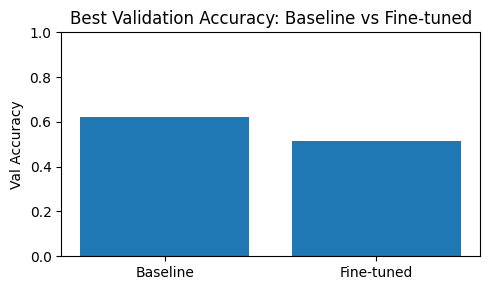


TRAINING HYBRID CNN + EXACT FEATURES
Piano roll data: (221, 128, 500, 1)
Hand-crafted features: (221, 13)
Hybrid model parameters: 41,593
Epoch 01 | lr=0.005000 | val_loss=1.9682
Epoch 02 | lr=0.005000 | val_loss=1.9060
Epoch 03 | lr=0.005000 | val_loss=1.9126
Epoch 04 | lr=0.005000 | val_loss=2.0827
Epoch 05 | lr=0.005000 | val_loss=2.3624
Epoch 06 | lr=0.005000 | val_loss=3.0164
Epoch 07 | lr=0.002500 | val_loss=3.7504
Epoch 08 | lr=0.002500 | val_loss=4.3766
Epoch 09 | lr=0.002500 | val_loss=4.2415
Epoch 10 | lr=0.002500 | val_loss=3.6699
Epoch 11 | lr=0.002500 | val_loss=5.8226
Epoch 12 | lr=0.001250 | val_loss=6.9735


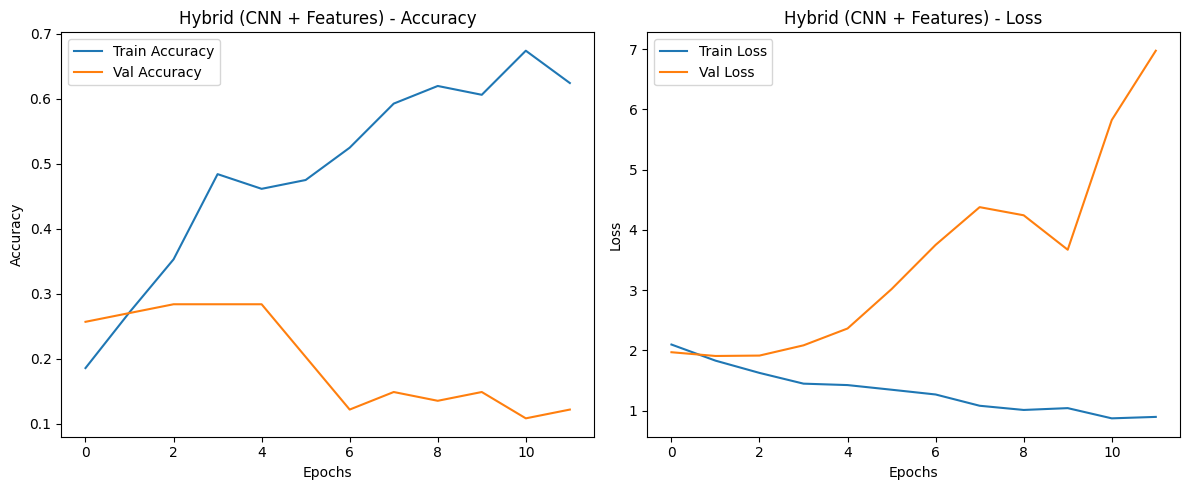

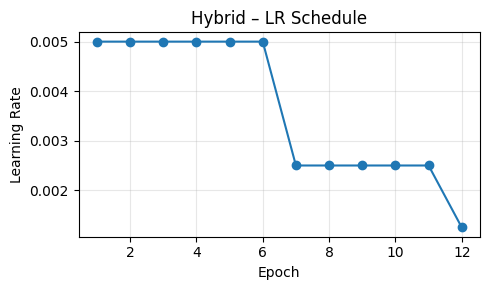

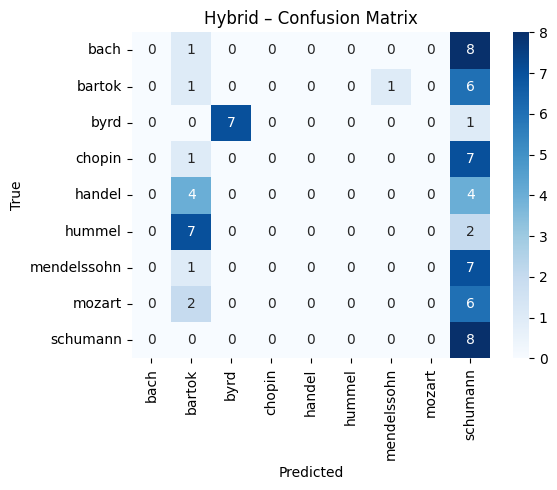

Best validation accuracy: 0.2838
Test accuracy: 0.2162

FINAL COMPARISON RESULTS:
Method                         Val Acc    Test Acc
--------------------------------------------------
Hand-crafted Only              0.6216     0.5000
Hybrid CNN + Hand-crafted      0.2838     0.2162
BEST METHOD: Hand-crafted Only
BEST VALIDATION ACCURACY: 0.6216
TEST ACCURACY: 0.5000

COMPARISON WITH TARGETS:
Previous CNN: 54.05%
Target: 59.46%
This approach: 62.2%
SUCCESS! Beat target by + 2.7%

Returned results dictionary: {'Hand-crafted Only': (0.6216216087341309, 0.5), 'Hybrid CNN + Hand-crafted': (0.28378379344940186, 0.21621622145175934)}


In [41]:
"""
main()
 └── comprehensive_comparison(csv_path)
      ├── load_data_with_exact_features(csv_path)
      │    → Loads piano roll data from CSV
      │    → Extracts EXACT 13 hand-crafted features
      │    → Encodes composer labels
      ├── train_handcrafted_only(...)
      │    → Scales features
      │    → Builds & trains NN using ONLY the 13 features
      │    → Evaluates on test set
      └── train_hybrid_model(...)
           → Processes piano rolls (center crop + reshape)
           → Scales features
           → Builds & trains HYBRID CNN + hand-crafted feature model
           → Evaluates on test set

Final output:
 - Prints validation & test accuracy for each method
 - Compares with previous CNN results & target accuracy
 - Returns a dictionary of results for further analysis
"""


def main():
    print("CNN + EXACT HAND-CRAFTED FEATURES")
    print("=" * 70)
    print("Using proven 13-feature extraction pipeline")
    print("=" * 70)

    csv_path = "saved_pianorolls/train_index.csv"

    # Run the comprehensive comparison directly
    results = comprehensive_comparison(csv_path)

    return results


if __name__ == "__main__":
    results = main()
    print("\nReturned results dictionary:", results)
